In [72]:
def comic_style(image_path, output_path='comic.jpg'):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read image")
        return None

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel = lab[:,:,0]
    edges = cv2.Canny(l_channel, 70, 150)

    def quantize_colors(img, k=6):
        Z = img.reshape((-1,3))
        Z = np.float32(Z)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        return res.reshape((img.shape))

    quantized = quantize_colors(img)

    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    edges = cv2.bitwise_not(edges)
    comic = cv2.bitwise_and(quantized, edges)
    comic = cv2.bilateralFilter(comic, d=9, sigmaColor=75, sigmaSpace=75)
    cv2.imwrite(output_path, comic)
    return comic

In [73]:
def sketch_style(image_path, output_path='sketch_output.jpg'):
    """Convert image to pencil sketch style"""
    img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    inverted_gray_img = 255 - gray_img
    blurred_img = cv2.GaussianBlur(inverted_gray_img, (21, 21), 0)
    inverted_blurred_img = 255 - blurred_img
    pencil_sketch = cv2.divide(gray_img, inverted_blurred_img, scale=256.0)
    cv2.imwrite(output_path, pencil_sketch)
    return pencil_sketch
# sketch_style('/content/test.png')

In [74]:
def pointillism_style(image_path, output_path='pointillism.jpg', dot_size=3):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    canvas = np.zeros((h, w, 3), dtype=np.uint8)
    canvas.fill(255)  # White background

    # Create random dots sampling colors from original image
    for _ in range(int(h*w*0.3)):  # Number of dots
        x, y = np.random.randint(0, w), np.random.randint(0, h)
        color = img[y, x]
        cv2.circle(canvas, (x, y), dot_size, color.tolist(), -1)
    cv2.imwrite(output_path, canvas)
    return canvas
# pointillism_style('/content/test.png')

In [75]:
def stained_glass_style(image_path, tile_size=15):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read image")
        return None

    h, w = img.shape[:2]
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            tile = img[y:y+tile_size, x:x+tile_size]
            mean_color = np.mean(tile, axis=(0,1))
            cv2.rectangle(img, (x, y), (x+tile_size, y+tile_size), mean_color, -1)
            cv2.rectangle(img, (x, y), (x+tile_size, y+tile_size), (0, 0, 0), 1)

    return img

In [76]:
def oil_painting_style(image_path, output_path='oil_output.jpg'):
    """Convert image to oil painting style using cv2.stylization"""
    img = cv2.imread(image_path)
    oil_img = cv2.stylization(img, sigma_s=60, sigma_r=0.45)
    cv2.imwrite(output_path, oil_img)
    return oil_img

def historic_style(image_path, output_path='historic_output.jpg'):
    """
    Convert image to a historic
    """
    img = cv2.imread(image_path)

    sepia_filter = np.array([[0.272, 0.534, 0.131],
                             [0.349, 0.686, 0.168],
                             [0.393, 0.769, 0.189]])
    historic_img = cv2.transform(img, sepia_filter)
    historic_img = np.clip(historic_img, 0, 255).astype(np.uint8)

    # Add a Gaussian blur to mimic lower sharpness of older photos.
    historic_img = cv2.GaussianBlur(historic_img, (7, 7), sigmaX=0)

    cv2.imwrite(output_path, historic_img)
    return historic_img


In [77]:
def mosaic_style(image_path, output_path='mosaic.jpg', pixel_size=10):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    small = cv2.resize(img, (w//pixel_size, h//pixel_size),
                      interpolation=cv2.INTER_NEAREST)
    mosaic = cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(output_path, mosaic)
    return mosaic
# mosaic_style('/content/test.png')

In [78]:
import cv2
import numpy as np

def ghibli_style(image_path, output_path='ghibli_output.jpg'):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read image")
        return None

    original_shape = img.shape[:2]

    # 2. Boost Colors (Vibrant yet soft)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    img_boosted = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    #  3. Smooth Texture using Edge-Preserving Filter
    smooth = cv2.edgePreservingFilter(img_boosted, flags=1, sigma_s=60, sigma_r=0.4)

    # 4.  Color Quantization (K-means with more clusters)
    Z = smooth.reshape((-1, 3))
    Z = np.float32(Z)
    K = 12  # More clusters for smoother gradients
    _, labels, centers = cv2.kmeans(Z, K, None,
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                                    5, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    quantized = centers[labels.flatten()].reshape((smooth.shape))

    # === 5. Outlines (Soft Laplacian Edges) ===
    gray = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Laplacian(blurred, cv2.CV_8U, ksize=5)
    edges = 255 - edges
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    edges_colored = (edges_colored * 0.4).astype(np.uint8)

    # === 6. Combine Quantized Colors and Edges ===
    outlined = cv2.addWeighted(quantized, 0.9, edges_colored, 0.1, 0)

    ghibli = np.clip(outlined, 0, 255).astype(np.uint8)
    cv2.imwrite(output_path, ghibli)
    return ghibli


In [79]:
def display_all_styles(input_path):
    # Load the original image
    if isinstance(input_path, str):
        original_img = Image.open(input_path).convert("RGB")
    elif isinstance(input_path, Image.Image):
        original_img = input_path.convert("RGB")
    else:
        raise ValueError("Unsupported input_path type")

    styles = {
        'Original': original_img,
        'Pencil Sketch': sketch_style(input_path),
        'Comic': comic_style(input_path),
        'Mosaic': mosaic_style(input_path),
        'Stained Glass': stained_glass_style(input_path),
        'Pointillism': pointillism_style(input_path),
        'Oil Painting': oil_painting_style(input_path),
        'Historic': historic_style(input_path),
        'Ghibli Style': ghibli_style(input_path)
    }

    num_styles = len(styles)
    cols = 3
    rows = (num_styles + cols - 1) // cols  # ceiling division

    plt.figure(figsize=(5 * cols, 4 * rows))
    plt.suptitle("Image Style Transformations", fontsize=20)

    for i, (style_name, styled_img) in enumerate(styles.items(), 1):
        plt.subplot(rows, cols, i)

        if isinstance(styled_img, Image.Image):
            display_img = np.array(styled_img.convert('RGB'))
            plt.imshow(display_img)
        elif isinstance(styled_img, np.ndarray):
            if len(styled_img.shape) == 3 and styled_img.shape[2] == 3:
                display_img = cv2.cvtColor(styled_img, cv2.COLOR_BGR2RGB)
                plt.imshow(display_img)
            elif len(styled_img.shape) == 2:
                plt.imshow(styled_img, cmap='gray')
            else:
                print(f"Unsupported image format for {style_name}")
                continue
        else:
            print(f"Unsupported image type for {style_name}")
            continue

        plt.title(style_name)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.show()


In [80]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image(image_path, title="Image"):
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()


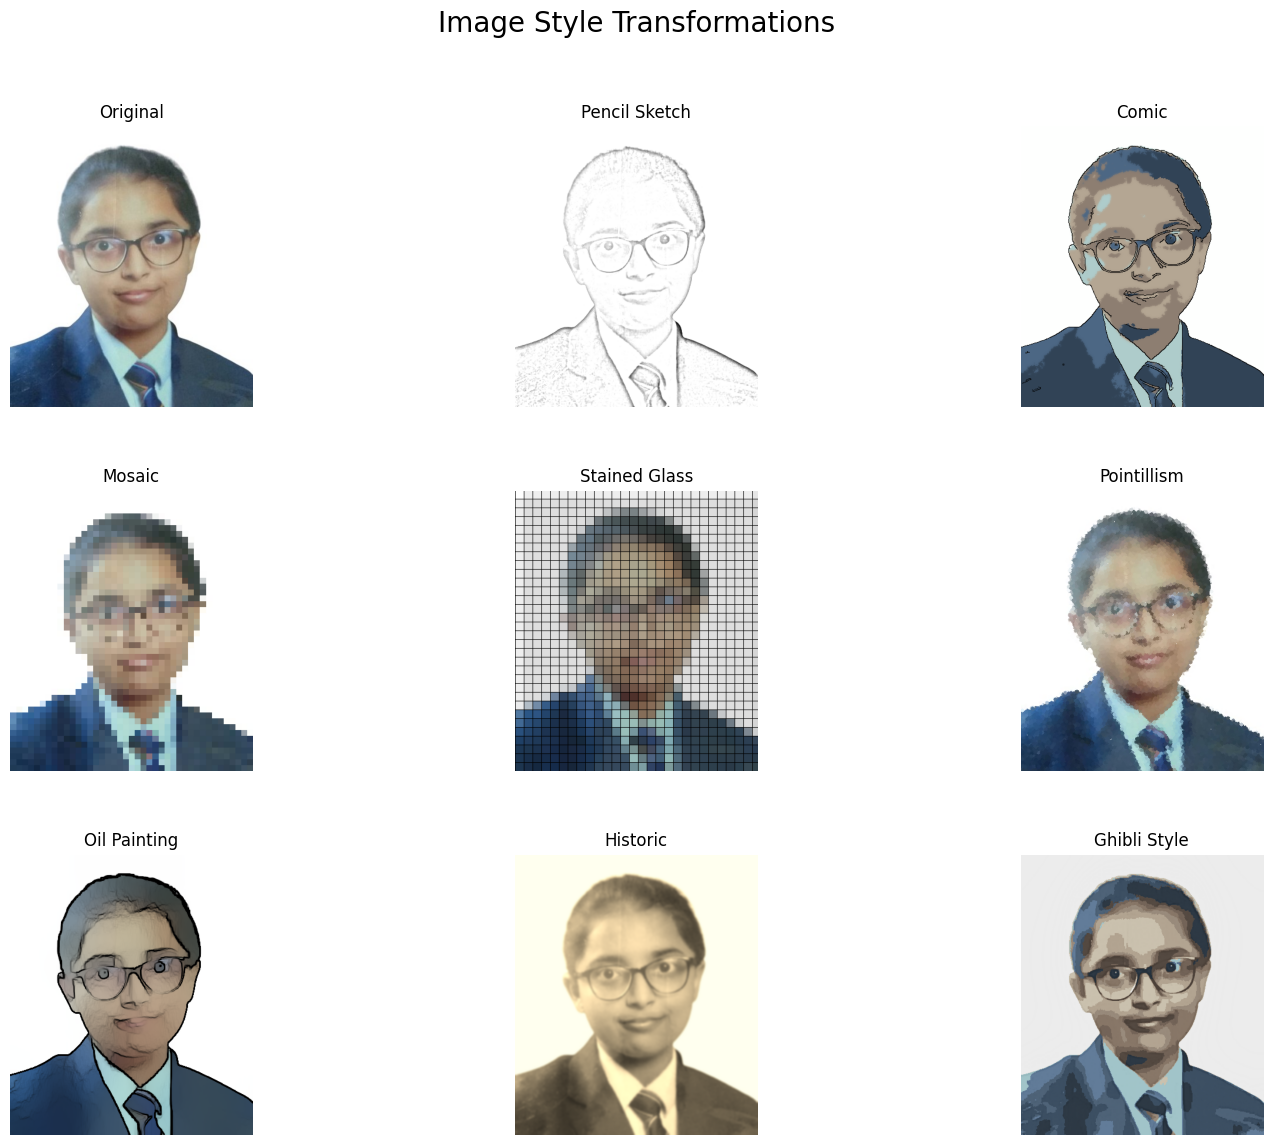

In [81]:
display_all_styles('/content/ankita2.jpeg')

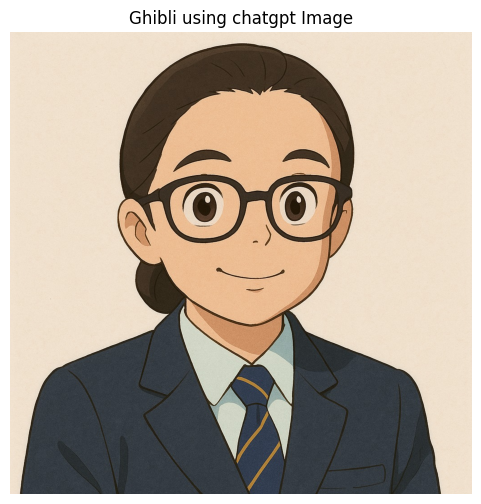

In [88]:
show_image("/content/chatgpt_ghibli_ankita.jpeg", title="Ghibli using chatgpt Image")

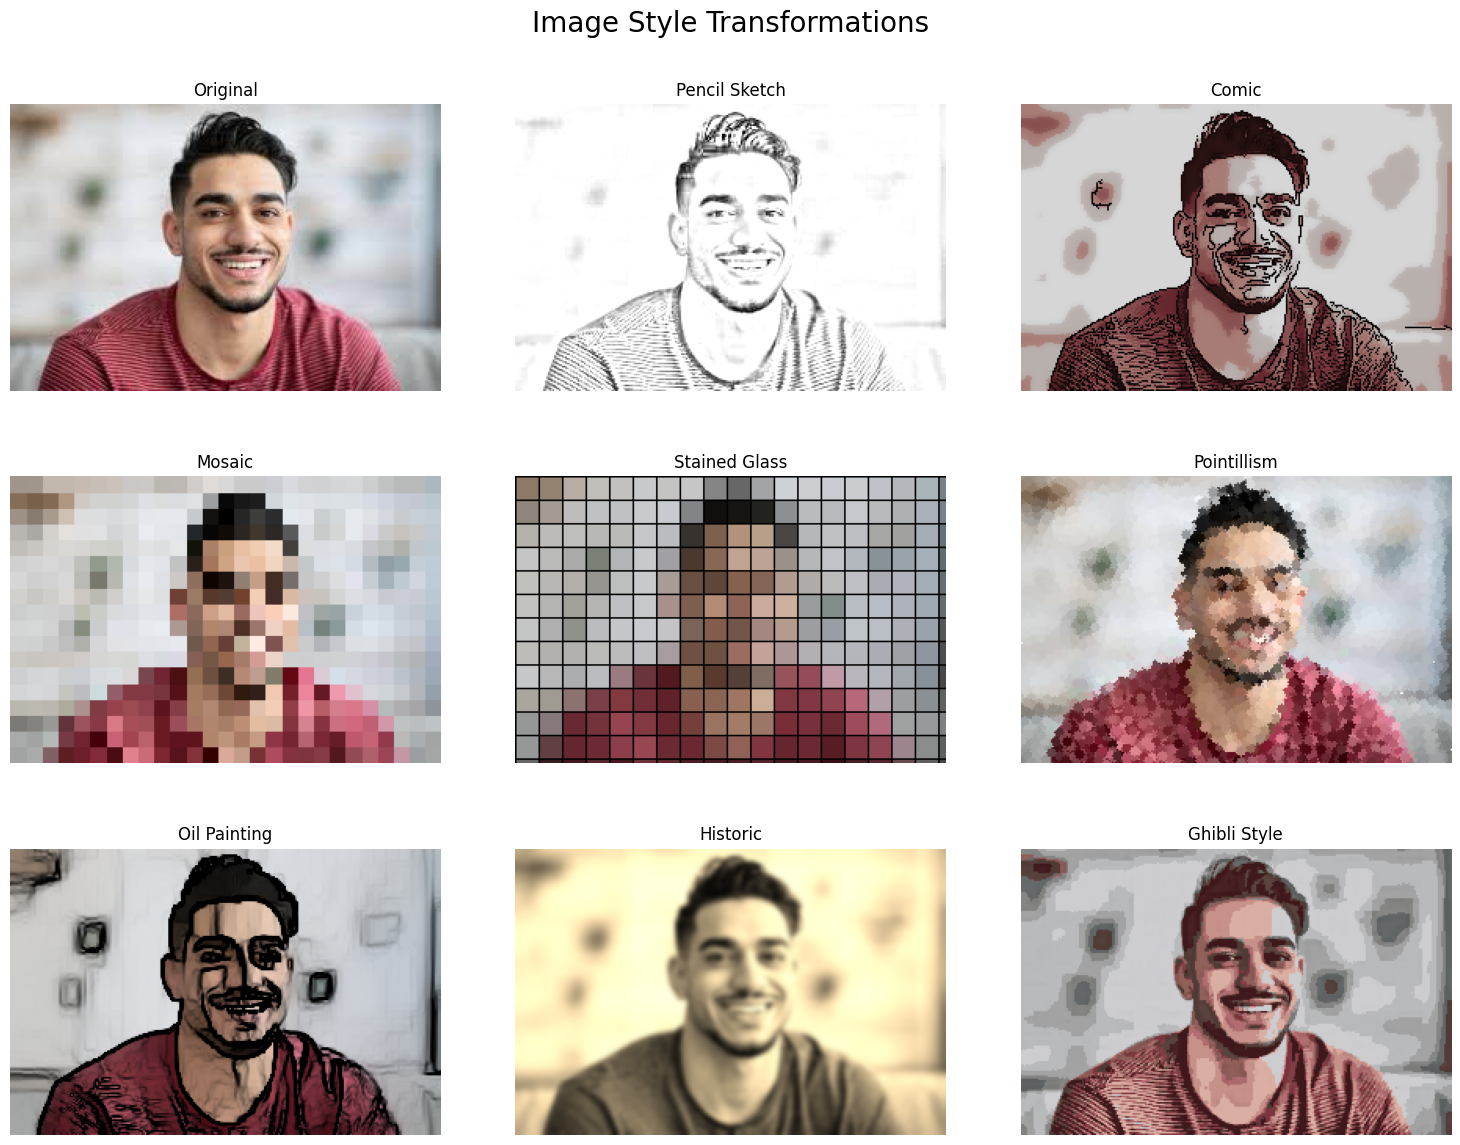

In [82]:
display_all_styles('/content/example01.jpeg')

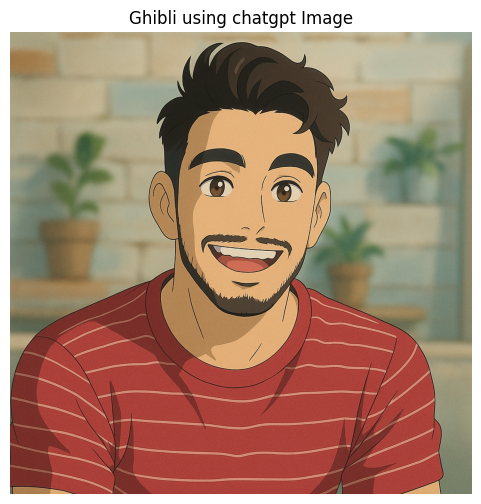

In [83]:
show_image("/content/chatgpt_ghibli_image01.png", title="Ghibli using chatgpt Image")


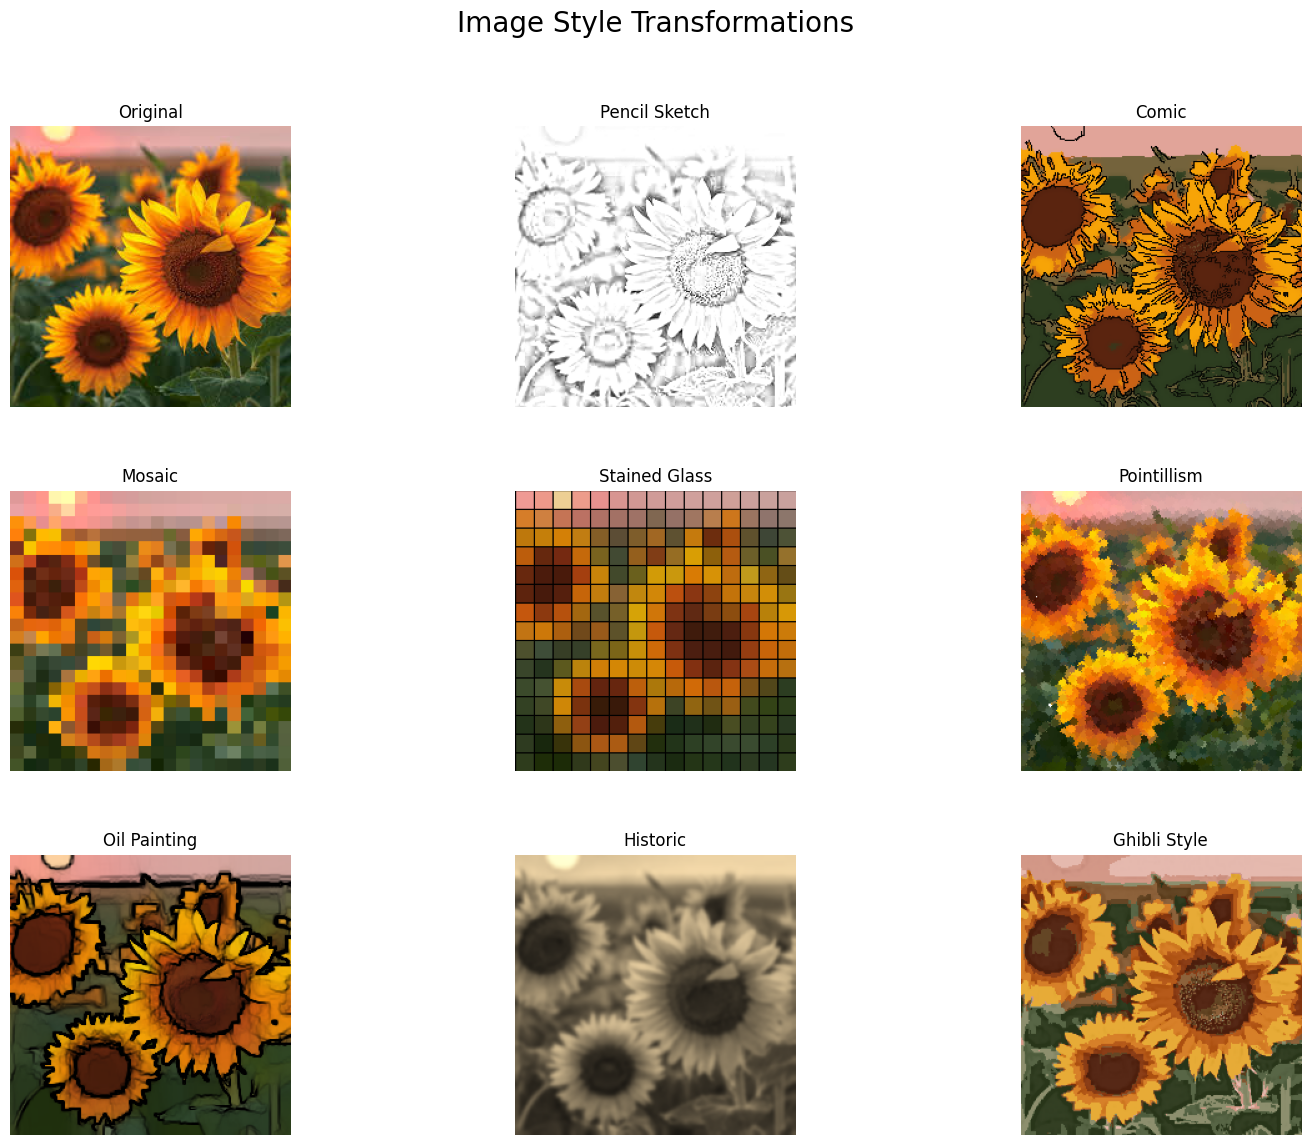

In [84]:
display_all_styles('/content/sunflower.jpg')

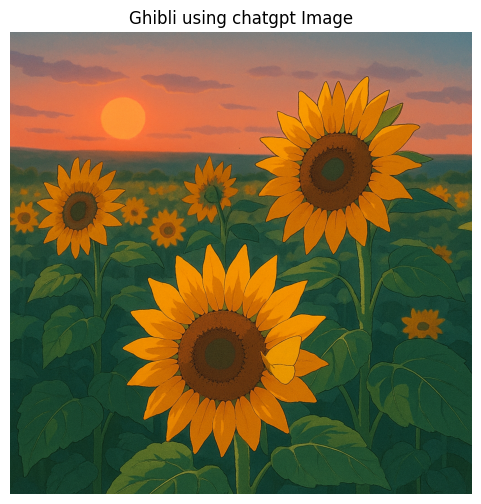

In [85]:
show_image("/content/ChatGPT_ghibli_sunflower.png", title="Ghibli using chatgpt Image")

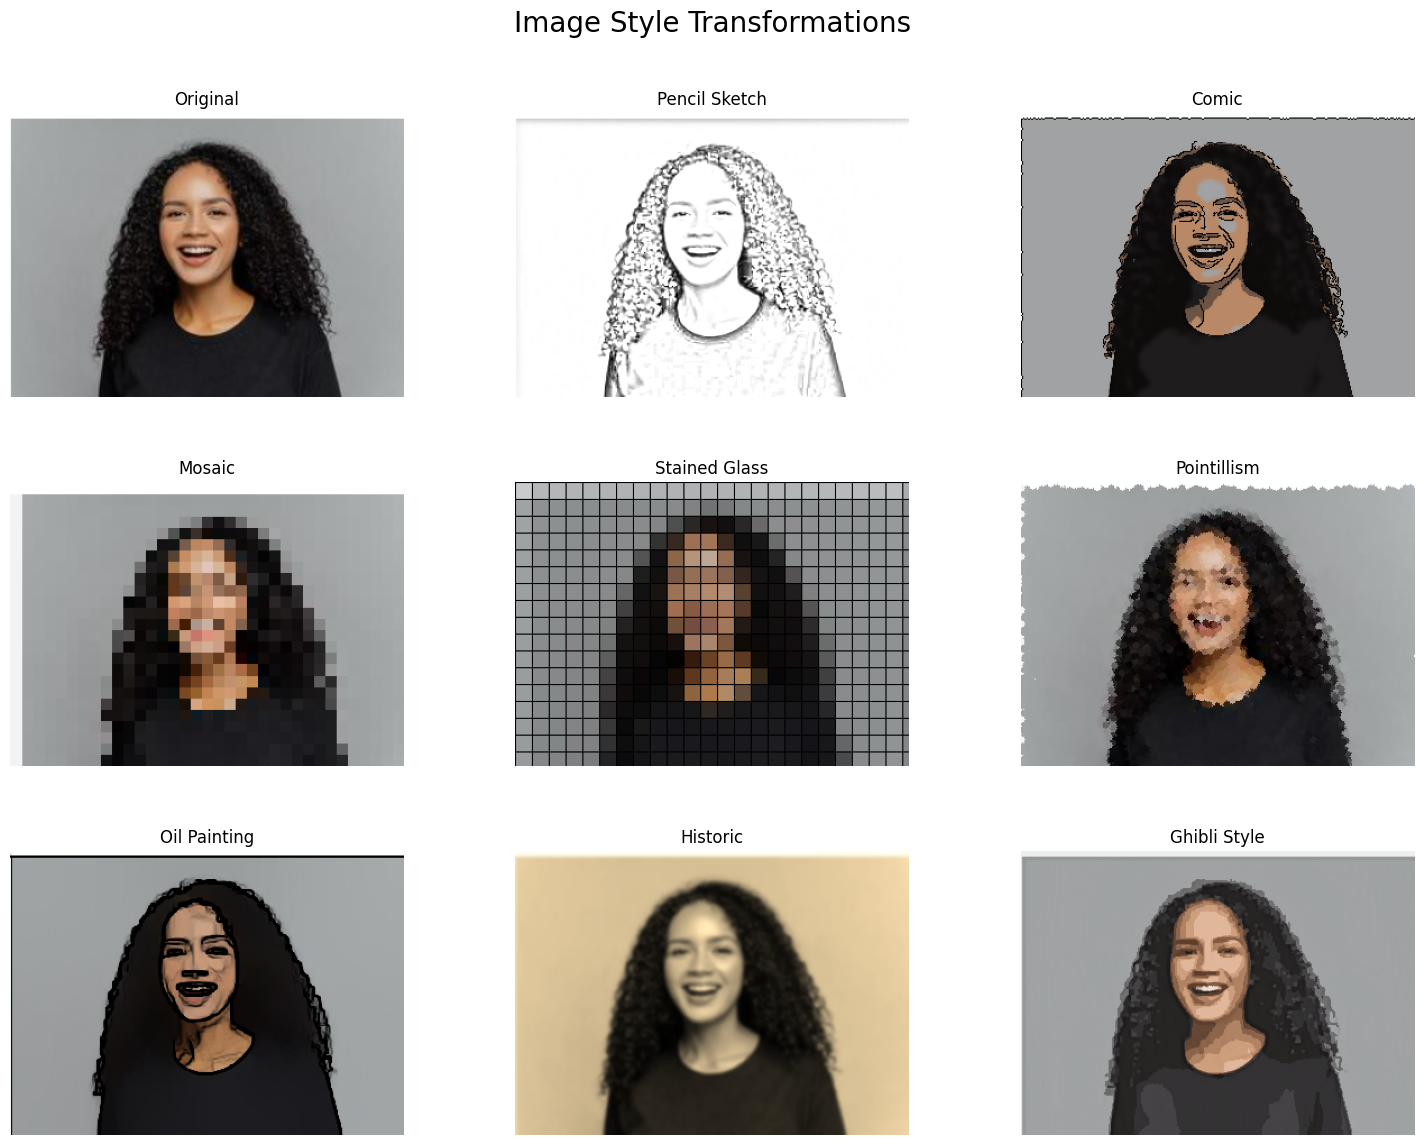

In [86]:
display_all_styles('/content/example02.png')

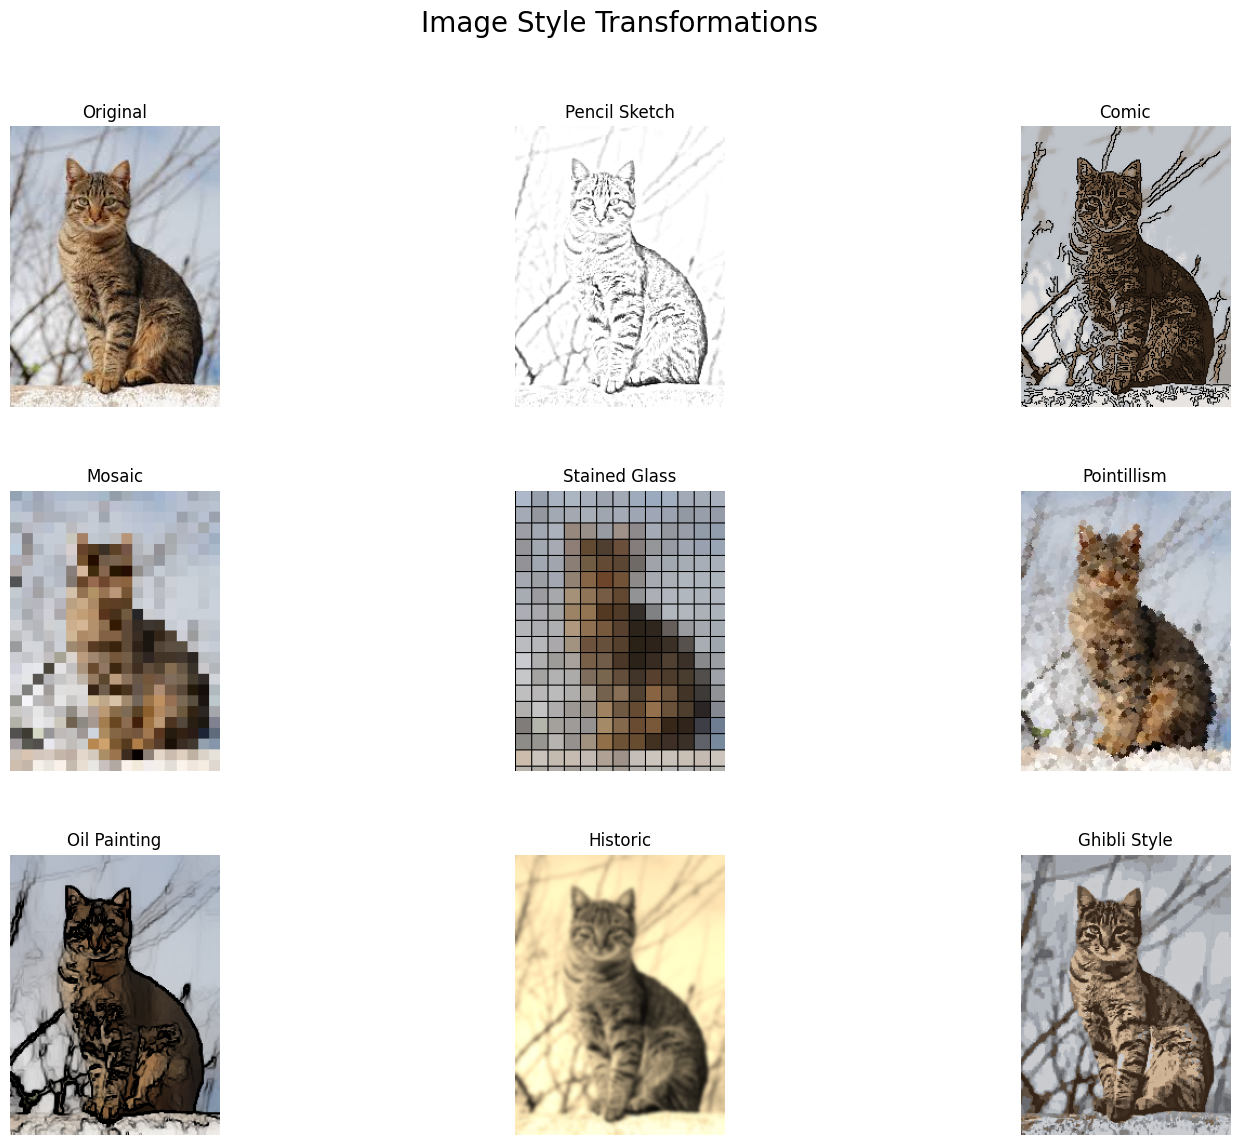

In [87]:
display_all_styles('/content/cat.jpg')